In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from sklearn.metrics import f1_score, accuracy_score
import cv2
import random
from torch.nn import functional as F
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
# 디바이스 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {DEVICE}")

# Seed 고정
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)
print("✅ 환경 설정 완료!")

🖥️ Device: cuda
✅ 환경 설정 완료!


In [2]:
# ============================
# Dataset 클래스
# ============================
class DocumentDataset(Dataset):
    def __init__(self, img_path, csv_path, img_h, img_w, is_train=True, use_mixup=False):
        self.img_path = img_path
        self.is_train = is_train
        self.use_mixup = use_mixup
        
        self.df = pd.read_csv(csv_path)
        self.num_classes = 17
        
        self.transform = A.Compose([
            A.Resize(height=img_h, width=img_w),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
        
        print(f"{'Train' if is_train else 'Val'} Dataset: {len(self.df)}개")
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        target = self.df.iloc[idx, 1]
        
        img_path = f"{self.img_path}/{img_id}"
        image = cv2.imread(img_path)
        
        # 이미지 로딩 실패 시 에러 처리
        if image is None:
            raise ValueError(f"이미지를 로드할 수 없습니다: {img_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.use_mixup and self.is_train and random.random() > 0.5:
            rand_idx = random.randint(0, len(self.df)-1)
            bg_id = self.df.iloc[rand_idx, 0]
            bg_target = self.df.iloc[rand_idx, 1]
            
            bg_img = cv2.imread(f"{self.img_path}/{bg_id}")
            if bg_img is None:
                # bg 이미지 로딩 실패 시 mixup 없이 진행
                y = F.one_hot(torch.tensor(target), num_classes=self.num_classes).float().contiguous()
            else:
                bg_img = cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB)
                bg_img = cv2.resize(bg_img, (image.shape[1], image.shape[0]))
                
                lam = np.random.beta(0.5, 0.5)
                image = (lam * image.astype(np.float32) + (1-lam) * bg_img.astype(np.float32)).astype(np.uint8)
                
                y = F.one_hot(torch.tensor(target), num_classes=self.num_classes).float().contiguous()
                bg_y = F.one_hot(torch.tensor(bg_target), num_classes=self.num_classes).float().contiguous()
                y = (lam * y + (1-lam) * bg_y).contiguous()
        else:
            y = F.one_hot(torch.tensor(target), num_classes=self.num_classes).float().contiguous()
        
        x = self.transform(image=image)['image']
        
        return x, y
print("✅ Dataset 클래스 정의 완료!")

✅ Dataset 클래스 정의 완료!


In [3]:
from efficientnet_pytorch import EfficientNet

# ============================
# EfficientNet 모델
# ============================
class EfficientNetClassifier(nn.Module):
    def __init__(self, model_name='efficientnet-b4', num_classes=17):
        super().__init__()
        self.backbone = EfficientNet.from_pretrained(model_name)
        in_features = self.backbone._fc.in_features
        self.backbone._fc = nn.Linear(in_features, num_classes)
    
    def forward(self, x):
        return self.backbone(x)

print("✅ 모델 클래스 정의 완료!")


✅ 모델 클래스 정의 완료!


In [4]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# ============================
# Label Smoothing Loss
# ============================
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing
    
    def forward(self, pred, target):
        n_class = pred.size(1)
        
        # target이 one-hot이면 argmax
        if target.dim() == 2:
            target = target.argmax(dim=1)
        
        one_hot = torch.zeros_like(pred).scatter(1, target.unsqueeze(1), 1)
        one_hot = one_hot * (1 - self.smoothing) + self.smoothing / n_class
        log_prob = F.log_softmax(pred, dim=1)
        loss = -(one_hot * log_prob).sum(dim=1).mean()
        return loss

print("✅ Loss & Scheduler 정의 완료!")


✅ Loss & Scheduler 정의 완료!


In [5]:
# ============================
# 하이퍼파라미터
# ============================
IMG_H, IMG_W = 380, 380  # 또는 512, 512
BATCH_SIZE = 16
EPOCHS = 30
LR = 1e-4
WEIGHT_DECAY = 1e-4

In [6]:
# ============================
# Dataset & DataLoader
# ============================
train_dataset = DocumentDataset(
    img_path='train_aug_50',
    csv_path='train_aug_50.csv',
    img_h=IMG_H,
    img_w=IMG_W,
    is_train=True,
    use_mixup=True
)

val_dataset = DocumentDataset(
    img_path='train',
    csv_path='val_split.csv',
    img_h=IMG_H,
    img_w=IMG_W,
    is_train=False,
    use_mixup=False
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"\n✅ DataLoader 준비 완료!")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")


Train Dataset: 237070개
Val Dataset: 314개

✅ DataLoader 준비 완료!
  - Train batches: 14817
  - Val batches: 20


In [7]:
# ============================
# 모델, Optimizer, Loss, Scheduler
# ============================
model = EfficientNetClassifier(model_name='efficientnet-b4', num_classes=17).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

print("✅ 모델 준비 완료!")
print(f"  - 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")


Loaded pretrained weights for efficientnet-b4
✅ 모델 준비 완료!
  - 파라미터 수: 17,579,097


In [8]:
# ============================
# 학습 루프 (Label Smoothing 대응)
# ============================
best_f1 = 0.0
train_losses = []
train_f1s = []
train_accs = []
val_f1s = []

patience = 3
counter = 0

for epoch in range(EPOCHS):
    try:
        # ============================
        # Train
        # ============================
        model.train()
        epoch_loss = 0.0
        train_preds = []
        train_targets = []
        
        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # ✅ 예측
            preds = outputs.argmax(dim=1).cpu().numpy()
            
            # ✅ Labels 처리 (one-hot이면 argmax)
            if labels.dim() > 1 and labels.shape[1] > 1:
                # One-hot encoding → 클래스 인덱스
                labels_np = labels.argmax(dim=1).cpu().numpy()
            else:
                # 이미 클래스 인덱스
                labels_np = labels.cpu().numpy()
            
            # ✅ 디버깅 (첫 배치만)
            if batch_idx == 0 and epoch == 0:
                print(f"\n🔍 첫 배치 디버깅:")
                print(f"  preds shape: {preds.shape}, dtype: {preds.dtype}")
                print(f"  labels_np shape: {labels_np.shape}, dtype: {labels_np.dtype}")
                print(f"  preds sample: {preds[:5]}")
                print(f"  labels sample: {labels_np[:5]}")
            
            # ✅ 리스트에 추가
            train_preds.extend(preds.flatten().tolist())
            train_targets.extend(labels_np.flatten().tolist())
        
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        scheduler.step()
        
        # ✅ F1 계산
        train_targets_arr = np.array(train_targets, dtype=np.int64)
        train_preds_arr = np.array(train_preds, dtype=np.int64)
        
        print(f"\n📊 Epoch {epoch+1} Train:")
        print(f"  Samples: {len(train_targets_arr)}")
        
        train_f1 = f1_score(train_targets_arr, train_preds_arr, average='macro')
        train_acc = accuracy_score(train_targets_arr, train_preds_arr)
        train_f1s.append(train_f1)
        train_accs.append(train_acc)

        # ============================
        # Validation
        # ============================
        model.eval()
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", leave=False):
                images = images.to(DEVICE)
                outputs = model(images)
                
                preds = outputs.argmax(dim=1).cpu().numpy()
                
                # ✅ Labels 처리 (one-hot이면 argmax)
                if labels.dim() > 1 and labels.shape[1] > 1:
                    labels_np = labels.argmax(dim=1).cpu().numpy()
                else:
                    labels_np = labels.cpu().numpy()
                
                val_preds.extend(preds.flatten().tolist())
                val_targets.extend(labels_np.flatten().tolist())
        
        val_targets_arr = np.array(val_targets, dtype=np.int64)
        val_preds_arr = np.array(val_preds, dtype=np.int64)
        
        val_f1 = f1_score(val_targets_arr, val_preds_arr, average='macro')
        val_f1s.append(val_f1)
        
        # ============================
        # Print Results
        # ============================
        print(f"\nEpoch {epoch+1}/{EPOCHS}:")
        print(f"  Train Loss={avg_loss:.4f}, Train F1={train_f1:.4f}, Train Acc={train_acc:.4f}")
        print(f"  Val F1={val_f1:.4f}")
        
        # ============================
        # Best Model Saving & Early Stopping
        # ============================
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_efficientb4.pth')
            print(f"  ✅ Best Model Saved! F1={best_f1:.4f}")
            counter = 0
        else:
            counter += 1
            print(f"  ⚠️ EarlyStopping: {counter}/{patience}")
            if counter >= patience:
                print("▶ Early stopping!")
                break
    
    except Exception as e:
        print(f"\n❌ 에러: {e}")
        import traceback
        traceback.print_exc()
        raise

print(f"\n🎯 Best Val F1: {best_f1:.4f}")



Epoch 1/30:   0%|          | 1/14817 [00:00<3:59:03,  1.03it/s]


🔍 첫 배치 디버깅:
  preds shape: (16,), dtype: int64
  labels_np shape: (16,), dtype: int64
  preds sample: [ 8 10  1 10  3]
  labels sample: [ 4  7 12  4  3]


Epoch 1/30: 100%|██████████| 14817/14817 [55:59<00:00,  4.41it/s]



📊 Epoch 1 Train:
  Samples: 237070



Epoch 1/30:
  Train Loss=0.7532, Train F1=0.9348, Train Acc=0.9374
  Val F1=1.0000
  ✅ Best Model Saved! F1=1.0000


Epoch 2/30: 100%|██████████| 14817/14817 [56:59<00:00,  4.33it/s] 



📊 Epoch 2 Train:
  Samples: 237070



Epoch 2/30:
  Train Loss=0.6549, Train F1=0.9721, Train Acc=0.9731
  Val F1=1.0000
  ⚠️ EarlyStopping: 1/3


Epoch 3/30: 100%|██████████| 14817/14817 [56:02<00:00,  4.41it/s]



📊 Epoch 3 Train:
  Samples: 237070



Epoch 3/30:
  Train Loss=0.6360, Train F1=0.9782, Train Acc=0.9788
  Val F1=1.0000
  ⚠️ EarlyStopping: 2/3


Epoch 4/30: 100%|██████████| 14817/14817 [56:04<00:00,  4.40it/s]



📊 Epoch 4 Train:
  Samples: 237070



Epoch 4/30:
  Train Loss=0.6244, Train F1=0.9823, Train Acc=0.9827
  Val F1=1.0000
  ⚠️ EarlyStopping: 3/3
▶ Early stopping!

🎯 Best Val F1: 1.0000


NameError: name 'val_f1_scores' is not defined

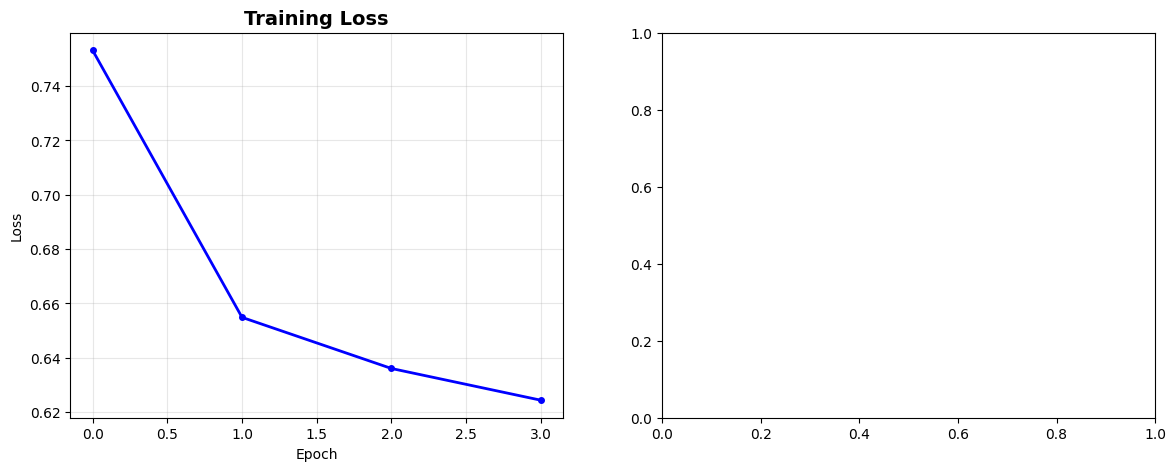

In [10]:
# ============================
# 학습 결과 시각화
# ============================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train Loss
axes[0].plot(train_losses, 'b-o', linewidth=2, markersize=4)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True, alpha=0.3)

# Val F1
axes[1].plot(val_f1_scores, 'g-o', linewidth=2, markersize=4)
axes[1].axhline(y=best_f1, color='r', linestyle='--', label=f'Best: {best_f1:.4f}')
axes[1].set_title('Validation F1 Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('efficientnet_b4_training.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 학습 결과 저장: efficientnet_b4_training.png")


In [12]:
# ============================
# 결과 요약
# ============================
print("\n" + "="*60)
print("🎯 EfficientNet-B4 학습 결과")
print("="*60)
print(f"  - Best Val F1: {best_f1:.4f}")
print(f"  - 최종 Train Loss: {train_losses[-1]:.4f}")
print(f"  - 최종 Val F1: {val_f1s[-1]:.4f}")
print(f"  - 모델 저장: best_efficientnet_b4.pth")
print("="*60)



🎯 EfficientNet-B4 학습 결과
  - Best Val F1: 1.0000
  - 최종 Train Loss: 0.6244
  - 최종 Val F1: 1.0000
  - 모델 저장: best_efficientnet_b4.pth
